In [ ]:
!pip install -q git+https://github.com/martinfleis/geopandas-view

# Tabular Geospatial Data

And these tools work well with tabular data too. Microsoft hosts a copy of the USDA's Forest Services' Forest Inventory Analysis in cloud-optimzied parquet format (processed by CarbonPlan).

> The mission of FIA is to determine the extent, condition, volume, growth, and use of trees 
of timber on the Nation's forest land.

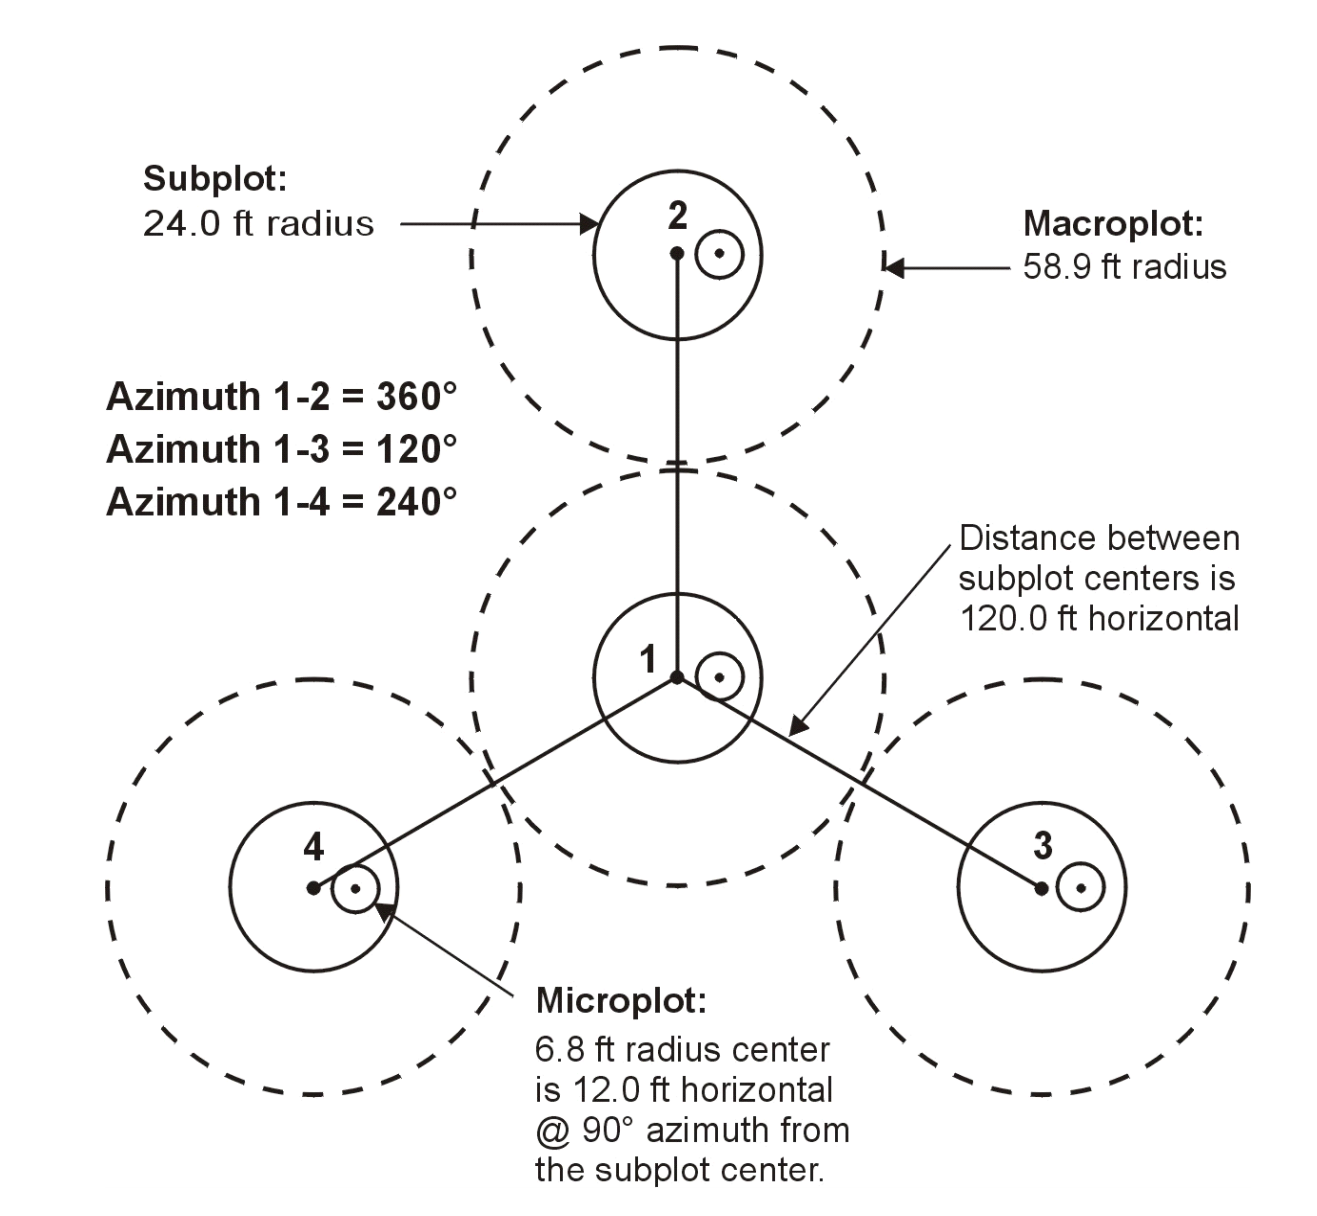

(Figurge 1.2 from the [FIADB User Guide](https://www.fia.fs.fed.us/library/database-documentation/current/ver80/FIADB%20User%20Guide%20P2_8-0.pdf))



In [ ]:
import fsspec
import adlfs
import dask
import dask.dataframe as dd
import pandas as pd
from dask_gateway import GatewayCluster
import requests
import shapely.geometry
import geopandas
from geopandas_view import view
import numpy as np

In [ ]:
cluster = GatewayCluster()
cluster.scale(32)
client = cluster.get_client()
cluster

In [ ]:
fs = adlfs.AzureBlobFileSystem(account_name="cpdataeuwest")
plot = dd.read_parquet("abfs://cpdata/raw/fia/plot.parquet", storage_options={"account_name": "cpdataeuwest"})
tree = dd.read_parquet("abfs://cpdata/raw/fia/tree.parquet", storage_options={"account_name": "cpdataeuwest"})

In [ ]:
plot, tree = dask.persist(plot, tree)

In [ ]:
plot  # plot description (see diagram above)

In [ ]:
tree  # measurements

In [ ]:
nbytes, = dask.compute(
    plot.memory_usage().sum() +
    tree.memory_usage().sum()
)
dask.utils.format_bytes(nbytes)

In [ ]:
result = (
    tree.assign(
        BIO_AG = lambda df: df.DRYBIO_AG * df["TPA_UNADJ"] / 2000,
        BIO_BG = lambda df: df.DRYBIO_BG * df["TPA_UNADJ"] / 2000,
        CARB_AG = lambda df: df.CARBON_AG * df["TPA_UNADJ"] / 2000,
        CARB_BG = lambda df: df.CARBON_BG * df["TPA_UNADJ"] / 2000,
    )
    .groupby(["STATECD", "COUNTYCD"])
    [["BIO_AG", "BIO_BG", "CARB_AG", "CARB_BG"]]
    .agg(["count", "sum"])
).compute()
result.columns = result.columns.to_flat_index().map("_".join)

result

In [ ]:
counties = requests.get("https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_050_00_5m.json").json()

In [ ]:
shapes = {
    (int(x["properties"]["STATE"]), int(x["properties"]["COUNTY"])): shapely.geometry.shape(x['geometry'])
    for x in counties['features']
}

In [ ]:
gdf = geopandas.GeoDataFrame(result, geometry=list(result.index.map(shapes))).dropna()
gdf

In [ ]:
columns = [
    "bio_ag", "BIO_AG_count", "BIO_AG_sum",
    "BIO_BG_sum", "CARB_AG_sum", "CARB_BG_sum", "geometry"
]

In [ ]:
view(gdf.assign(bio_ag=lambda x: np.log1p(x["BIO_AG_sum"]))[columns].round(2), column="bio_ag")